In [95]:
# enable automatic reloading of the notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demo: sequences <-> networks
The following notebook provides a demonstration how the ts2g2 library can be used to convert time series into graphs and graphs into time series. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN) and Apple stock (APPLE). All the column desinpiptions are provided. Currency is USD.

In [96]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

#import os
import csv
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from timeseries.strategies import TimeseriesToGraphStrategy, TimeseriesEdgeVisibilityConstraintsNatural, TimeseriesEdgeVisibilityConstraintsHorizontal, EdgeWeightingStrategyNull, TimeseriesEdgeVisibilityConstraintsVisibilityAngle
from generation.strategies import RandomWalkWithRestartSequenceGenerationStrategy, RandomWalkSequenceGenerationStrategy, RandomNodeSequenceGenerationStrategy, RandomNodeNeighbourSequenceGenerationStrategy, RandomDegreeNodeSequenceGenerationStrategy
from core import model 
from sklearn.model_selection import train_test_split
import itertools

import xml.etree.ElementTree as ET

import input as inp
import builder.graph_strategy as gs
import graph
import link
import singular as sg

# Accessing data
We first get path to the data.

In [97]:
amazon_path = os.path.join(os.getcwd(), "amazon", "AMZN.csv")
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")

# Converting time series to graph
Here are two examples of conversion of data from time serie to graph. Second one is inpeated using sliding window mechanism. That means its nodes are smaller graphs inpeated based on a segments of data (length = 5).

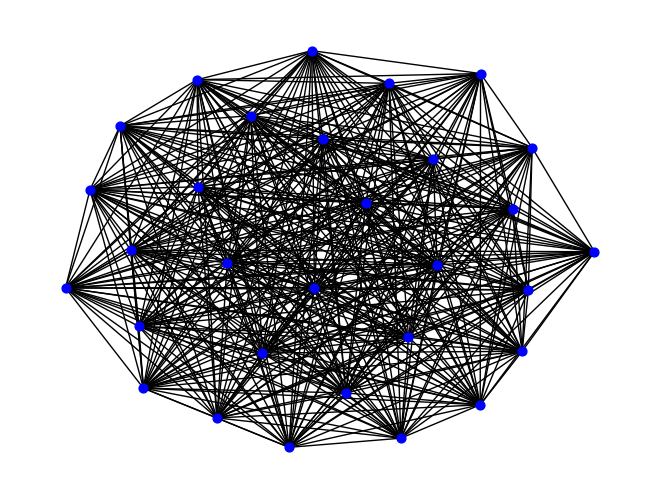

In [98]:
test = sg.TimeSeriesPreprocessing(inp.CsvStock(amazon_path, "Close").from_csv())\
    .add_strategy(sg.Segmentation(60, 90))\
    .process()\
    .to_graph(gs.NaturalVisibility().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(link.LinkNodesWithinGraph().by_value(link.SameValue(2)).seasonalities(15))\
    .draw("blue")


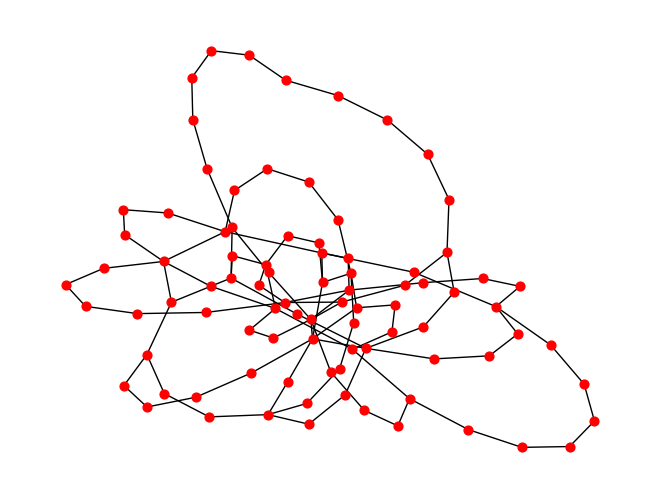

In [99]:
x = sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(sg.Segmentation(60, 190))\
    .add_strategy(sg.SlidingWindow(5))\
    .process()\
    .to_graph(gs.NaturalVisibility().get_strategy())\
    .link(link.LinkGraphs().sliding_window())\
    .combine_identical_nodes_slid_win()\
    .draw("red")

# Combining multiple graphs
We can store and combine multiple of already inpeated objects TimeSeriesToGraph into one object MultivariateTimeSeriesToGraph

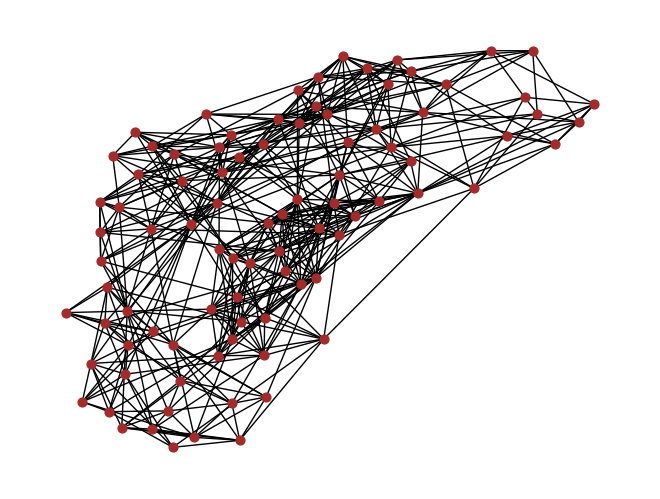

In [100]:
i = sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(sg.Segmentation(60, 90))\
    .process()\
    .add(sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
        .add_strategy(sg.Segmentation(90, 120))\
        .process())\
    .add(sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
        .add_strategy(sg.Segmentation(150, 180))\
        .process())\
    .to_graph(gs.NaturalVisibility().with_limit(1).get_strategy())\
    .link(link.LinkGraphs().time_coocurence())\
    .link(link.LinkNodesWithinGraph().by_value(link.SameValue(0.5)))\
    .draw("brown")

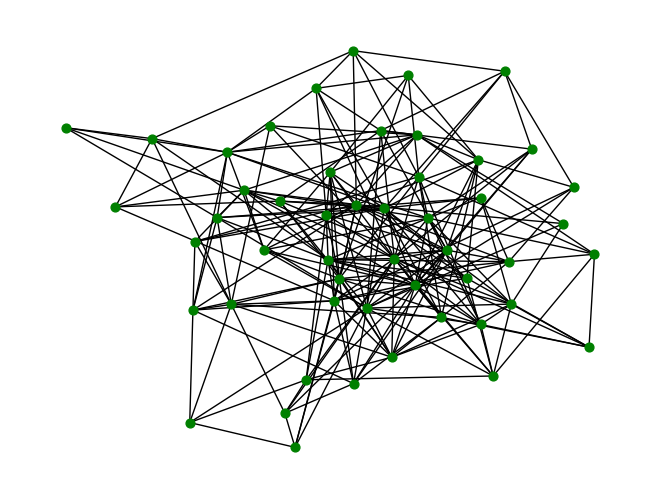

In [101]:
j = sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(sg.Segmentation(60, 110))\
    .add_strategy(sg.SlidingWindow(5))\
    .process()\
    .add(sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
         .add_strategy(sg.Segmentation(90, 140))\
            .add_strategy(sg.SlidingWindow(5))\
                .process())\
    .add(sg.TimeSeriesPreprocessing(inp.CsvStock(apple_path, "Close").from_csv())\
         .add_strategy(sg.Segmentation(150, 200))\
            .add_strategy(sg.SlidingWindow(5))\
                .process())\
    .to_graph(gs.NaturalVisibility().get_strategy())\
    .link(link.LinkGraphs().sliding_window().time_coocurence())\
    .combine_identical_nodes_slid_win()\
    .link(link.LinkNodesWithinGraph().seasonalities(15))\
    .draw("green")

# Back to time series
We can convert existing graphs back to time series based on our strategy.

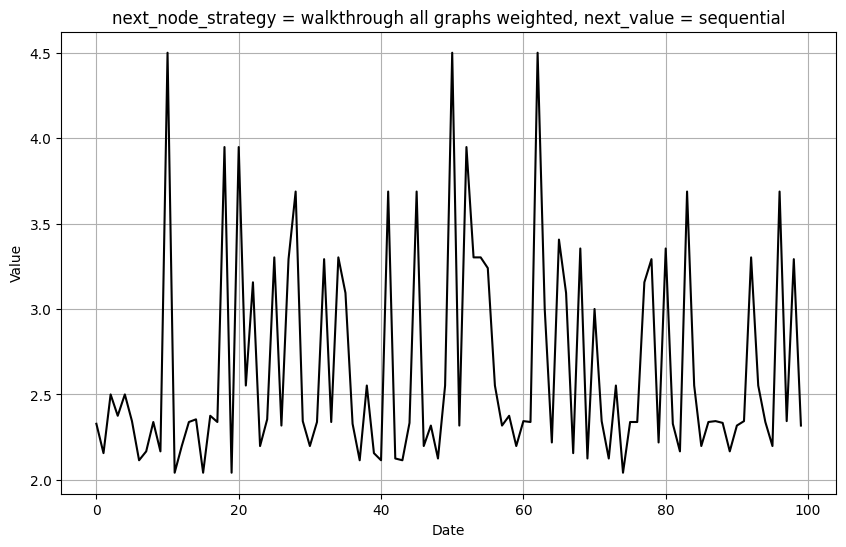

In [102]:
graph.GraphToTS(test.get_graph())\
    .set_nodes(test.get_graphs())\
    .next_node_strategy(graph.NextNodeAllWeighted())\
    .next_value_strategy(graph.NextValueSequential().skip_every_x_steps(1))\
    .ts_length(100)\
    .to_multiple_time_sequences()\
    .draw()

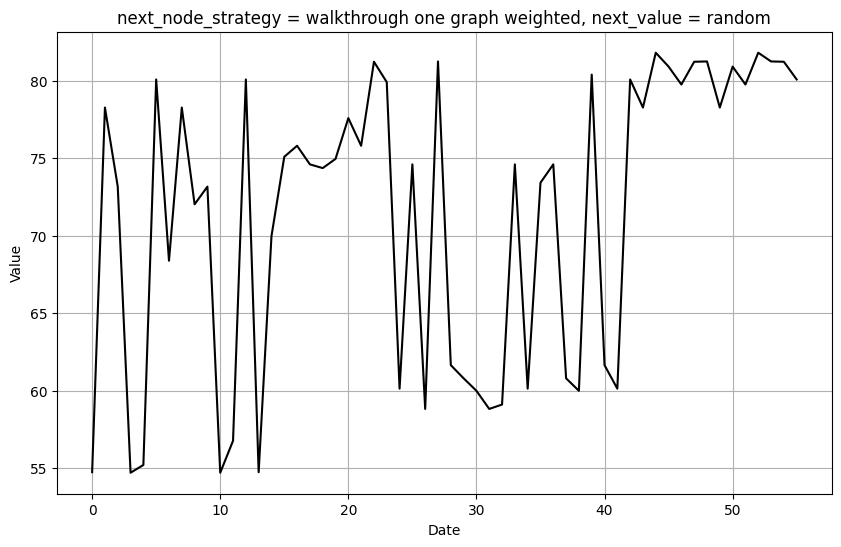

In [103]:
graph.GraphSlidWin(x.get_graph())\
    .set_nodes(x.get_graphs())\
    .next_node_strategy(graph.NextNodeOneWeighted())\
    .next_value_strategy(graph.NextValueRandomSlidWin().skip_every_x_steps(1))\
    .ts_length(50)\
    .to_time_sequence()\
    .draw()

We can also convert our multivriate graphs back to multiple time series.

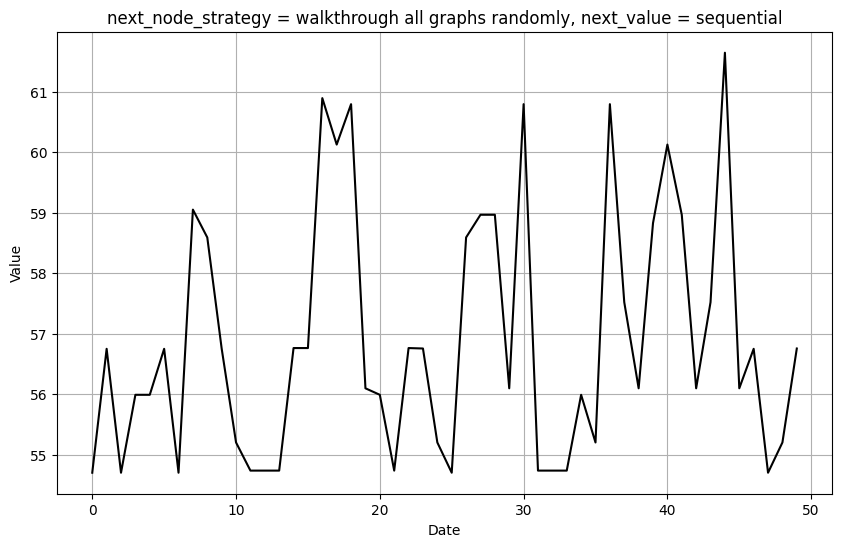

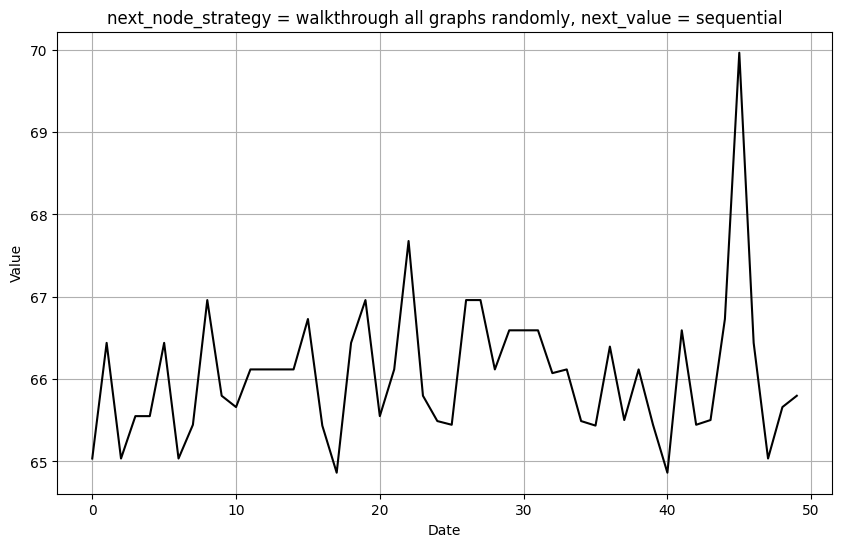

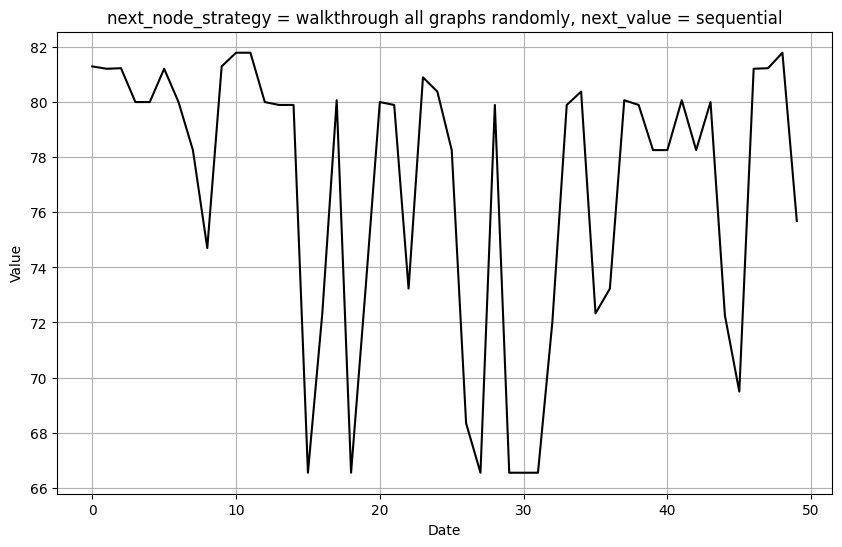

In [104]:
graph.GraphToTS(i.get_graph())\
    .set_nodes(i.get_graphs())\
    .next_node_strategy(graph.NextNodeAllRandom().change_graphs_every_x_steps(2))\
    .next_value_strategy(graph.NextValueSequential().skip_every_x_steps(1))\
    .ts_length(50)\
    .to_multiple_time_sequences()\
    .draw()

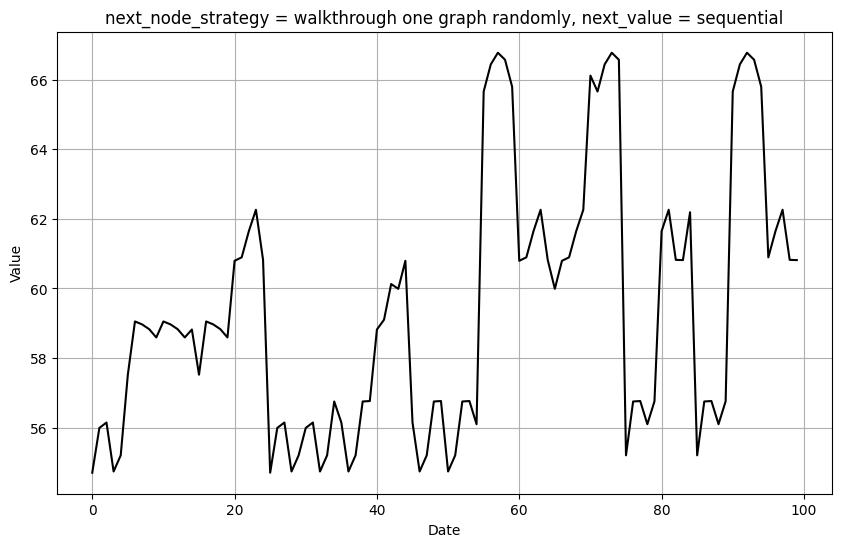

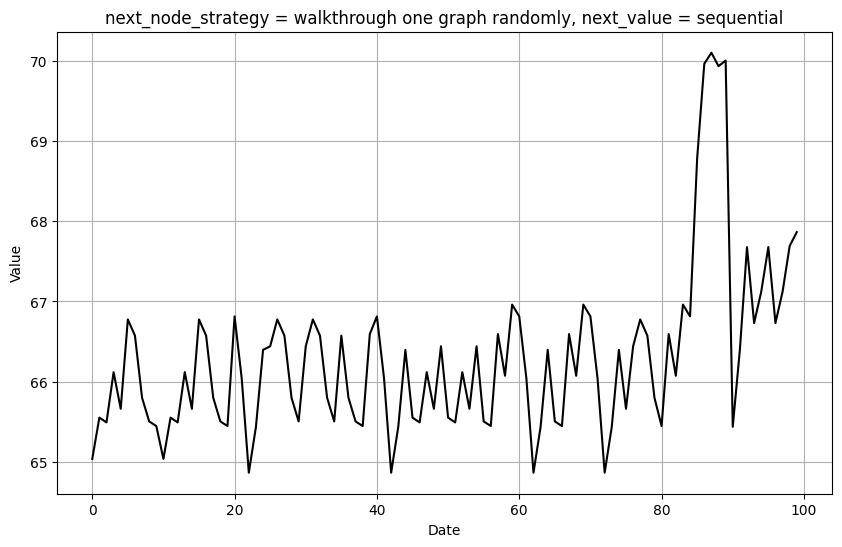

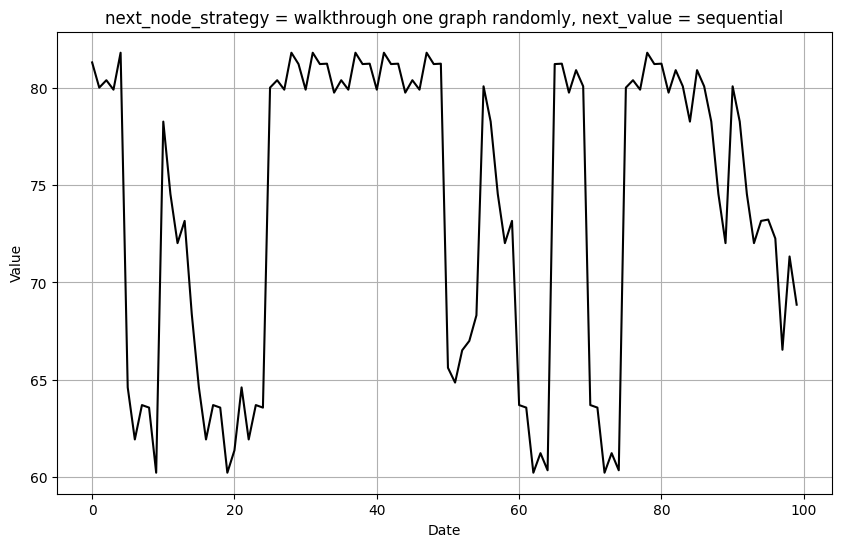

In [105]:
graph.GraphSlidWin(j.get_graph())\
    .set_nodes(j.get_graphs())\
    .next_node_strategy(graph.NextNodeOneRandom())\
    .next_value_strategy(graph.NextValueSequentialSlidWin())\
    .ts_length(100)\
    .to_multiple_time_sequences()\
    .draw()